In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import numpy as np
import scipy
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import seaborn as sns

# Set matplotlib and seaborn plotting style
sns.set_style('darkgrid')
np.random.seed(42)

### Website Links

1. Multivariate Normal Distribution [https://peterroelants.github.io/posts/multivariate-normal-primer/]

1. Gaussian Process Regression [https://peterroelants.github.io/posts/gaussian-process-tutorial/]

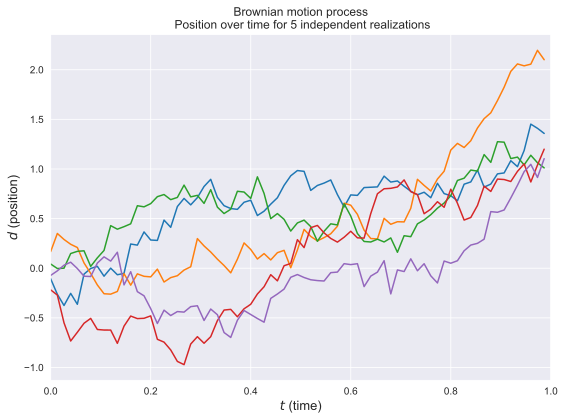

In [4]:
# 1D simulation of the Brownian motion process
total_time = 1
nb_steps = 75
delta_t = total_time / nb_steps
nb_processes = 5  # Simulate 5 different motions
mean = 0.  # Mean of each movement
stdev = np.sqrt(delta_t)  # Standard deviation of each movement

# Simulate the brownian motions in a 1D space by cumulatively
#  making a new movement delta_d
distances = np.cumsum(
    # Move randomly from current location to N(0, delta_t)
    np.random.normal(
        mean, stdev, (nb_processes, nb_steps)),
    axis=1)

plt.figure(figsize=(8, 6))
# Make the plots
t = np.arange(0, total_time, delta_t)
for i in range(nb_processes):
    plt.plot(t, distances[i,:])
plt.title((
    'Brownian motion process\n '
    'Position over time for 5 independent realizations'))
plt.xlabel('$t$ (time)', fontsize=13)
plt.ylabel('$d$ (position)', fontsize=13)
plt.xlim([-0, 1])
plt.tight_layout()
plt.show()

In [6]:
# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * scipy.spatial.distance.cdist(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

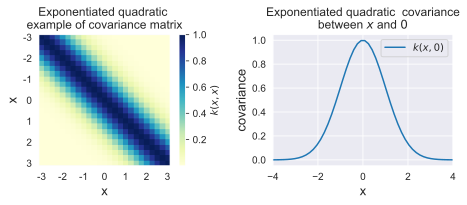

In [7]:
# Illustrate covariance matrix and function

# Show covariance matrix example from exponentiated quadratic
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
xlim = (-3, 3)
X = np.expand_dims(np.linspace(*xlim, 25), 1)
Σ = exponentiated_quadratic(X, X)
# Plot covariance matrix
im = ax1.imshow(Σ, cmap=cm.YlGnBu)
cbar = plt.colorbar(
    im, ax=ax1, fraction=0.045, pad=0.05)
cbar.ax.set_ylabel('$k(x,x)$', fontsize=10)
ax1.set_title((
    'Exponentiated quadratic \n'
    'example of covariance matrix'))
ax1.set_xlabel('x', fontsize=13)
ax1.set_ylabel('x', fontsize=13)
ticks = list(range(xlim[0], xlim[1]+1))
ax1.set_xticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_yticks(np.linspace(0, len(X)-1, len(ticks)))
ax1.set_xticklabels(ticks)
ax1.set_yticklabels(ticks)
ax1.grid(False)

# Show covariance with X=0
xlim = (-4, 4)
X = np.expand_dims(np.linspace(*xlim, num=50), 1)
zero = np.array([[0]])
Σ0 = exponentiated_quadratic(X, zero)
# Make the plots
ax2.plot(X[:,0], Σ0[:,0], label='$k(x,0)$')
ax2.set_xlabel('x', fontsize=13)
ax2.set_ylabel('covariance', fontsize=13)
ax2.set_title((
    'Exponentiated quadratic  covariance\n'
    'between $x$ and $0$'))
# ax2.set_ylim([0, 1.1])
ax2.set_xlim(*xlim)
ax2.legend(loc=1)

fig.tight_layout()
plt.show()

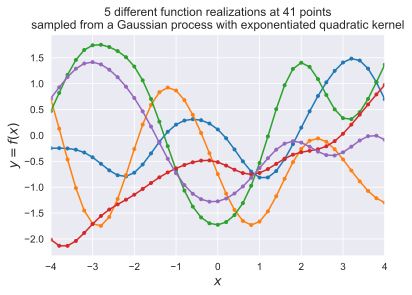

In [22]:
# Sample from the Gaussian process distribution
nb_of_samples = 41  # Number of points in each function
number_of_functions = 5  # Number of functions to sample
# Independent variable samples
X = np.expand_dims(np.linspace(-4, 4, nb_of_samples), 1)
Σ = exponentiated_quadratic(X, X)  # Kernel of data points

# Draw samples from the prior at our data points.
# Assume a mean of 0 for simplicity
ys = np.random.multivariate_normal(
    mean=np.zeros(nb_of_samples), cov=Σ, 
    size=number_of_functions)

# print(Σ[0].round(15))

# Plot the sampled functions
plt.figure(figsize=(6, 4))
for i in range(number_of_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.xlabel('$x$', fontsize=13)
plt.ylabel('$y = f(x)$', fontsize=13)
plt.title((
    '5 different function realizations at 41 points\n'
    'sampled from a Gaussian process with exponentiated quadratic kernel'))
plt.xlim([-4, 4])
plt.show()

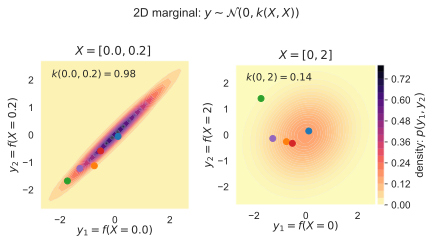

In [23]:
def generate_surface(mean, covariance, surface_resolution):
    """Helper function to generate density surface."""
    x1s = np.linspace(-5, 5, num=surface_resolution)
    x2s = np.linspace(-5, 5, num=surface_resolution)
    x1, x2 = np.meshgrid(x1s, x2s) # Generate grid
    pdf = np.zeros((surface_resolution, surface_resolution))
    # Fill the cost matrix for each combination of weights
    for i in range(surface_resolution):
        for j in range(surface_resolution):
            pdf[i,j] = scipy.stats.multivariate_normal.pdf(
                np.array([x1[i,j], x2[i,j]]), 
                mean=mean, cov=covariance)
    return x1, x2, pdf  # x1, x2, pdf(x1,x2)

surface_resolution = 50  # Resolution of the surface to plot
fig = plt.figure(figsize=(6.2, 3.5)) 
gs = gridspec.GridSpec(1, 2)
ax_p1 = plt.subplot(gs[0,0])
ax_p2 = plt.subplot(gs[0,1], sharex=ax_p1, sharey=ax_p1)

# Plot of strong correlation
X_strong = np.array([[0], [0.2]])
μ = np.array([0., 0.])
Σ_strong = exponentiated_quadratic(X_strong, X_strong)
y1, y2, p = generate_surface(μ, Σ_strong, surface_resolution=surface_resolution)
# Plot bivariate distribution
con1 = ax_p1.contourf(y1, y2, p, 25, cmap=cm.magma_r)
ax_p1.set_xlabel(
    f'$y_1 = f(X={X_strong[0,0]})$', 
    fontsize=11, labelpad=0)
ax_p1.set_ylabel(
    f'$y_2 = f(X={X_strong[1,0]})$', 
    fontsize=11)
ax_p1.axis([-2.7, 2.7, -2.7, 2.7])
ax_p1.set_aspect('equal')
ax_p1.text(
    -2.3, 2.1, 
    (f'$k({X_strong[0,0]}, {X_strong[1,0]}) '
     f'= {Σ_strong[0,1]:.2f}$'), 
    fontsize=10)
ax_p1.set_title(
    f'$X = [{X_strong[0,0]}, {X_strong[1,0]}]$ ', 
    fontsize=12)
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_02_index = np.where(np.isclose(X, 0.2))
y_strong = ys[:,[X_0_index[0][0], X_02_index[0][0]]]
# Show samples on surface
for i in range(y_strong.shape[0]):
    ax_p1.plot(y_strong[i,0], y_strong[i,1], marker='o')

# Plot weak correlation
X_weak = np.array([[0], [2]])
μ = np.array([0., 0.])
Σ_weak = exponentiated_quadratic(X_weak, X_weak)
y1, y2, p = generate_surface(μ, Σ_weak, surface_resolution=surface_resolution)
# Plot bivariate distribution
con2 = ax_p2.contourf(y1, y2, p, 25, cmap=cm.magma_r)
con2.set_cmap(con1.get_cmap())
con2.set_clim(con1.get_clim())
ax_p2.set_xlabel(
    f'$y_1 = f(X={X_weak[0,0]})$', 
    fontsize=11, labelpad=0)
ax_p2.set_ylabel(
    f'$y_2 = f(X={X_weak[1,0]})$', 
    fontsize=11)
ax_p2.set_aspect('equal')
ax_p2.text(
    -2.3, 2.1, 
    (f'$k({X_weak[0,0]}, {X_weak[1,0]}) '
     f'= {Σ_weak[0,1]:.2f}$'), 
    fontsize=10)
ax_p2.set_title(
    f'$X = [{X_weak[0,0]}, {X_weak[1,0]}]$', 
    fontsize=12)
# Add colorbar
divider = make_axes_locatable(ax_p2)
cax = divider.append_axes('right', size='5%', pad=0.02)
cbar = plt.colorbar(con1, ax=ax_p2, cax=cax)
cbar.ax.set_ylabel('density: $p(y_1, y_2)$', fontsize=11)
fig.suptitle('2D marginal: $y \sim \mathcal{N}(0, k(X, X))$')
# Select samples
X_0_index = np.where(np.isclose(X, 0.))
X_2_index = np.where(np.isclose(X, 2.))
y_weak = ys[:,[X_0_index[0][0], X_2_index[0][0]]]
# Show samples on surface
for i in range(y_weak.shape[0]):
    ax_p2.plot(y_weak[i,0], y_weak[i,1], marker='o')

plt.tight_layout()
plt.show()